In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sfma import Data, SFMAModel, Variable, SplineVariable, SplineGetter, SplinePriorGetter, UniformPrior

In [2]:
df = pd.read_csv("../data/gdp-le.csv")

In [3]:
df = df.loc[~np.isnan(df.gdp.values)]
df = df.loc[~np.isnan(df[["le"]].values)]

df["se"] = 0.01

df["log.le"] = np.log(df["le"])
df["log.gdp"] = np.log(df["gdp"])

df.sort_values('gdp', inplace=True)

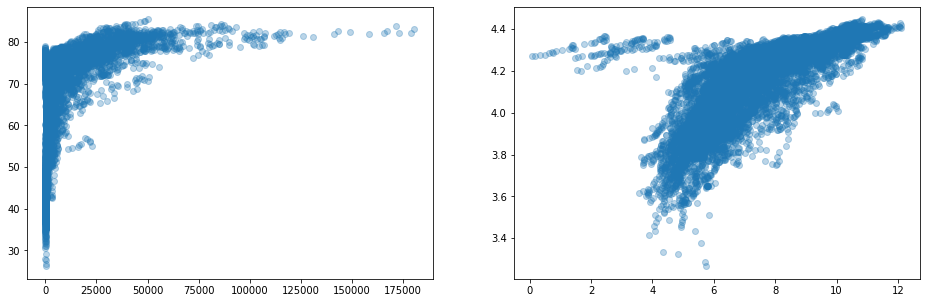

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].scatter(df[["gdp"]], df[["le"]], alpha=0.3)
ax[1].scatter(np.log(df[["gdp"]]), np.log(df[["le"]]), alpha=0.3)

In [5]:
x_var = "log.gdp"
y_var = "log.le"

In [6]:
data = Data(
    obs=y_var,
    obs_se="se"
)

In [7]:
priors = [
    SplinePriorGetter(UniformPrior(lb=0.0, ub=np.inf), order=1, size=20),
    SplinePriorGetter(UniformPrior(lb=-np.inf, ub=0.0), order=2, size=20)
]

variables = [
    SplineVariable(x_var,
                   spline=SplineGetter(knots=np.linspace(0.0, 1.0, 5),
                                       degree=2,
                                       r_linear=True,
                                       l_linear=True,
                                       knots_type="rel_domain",
                                       include_first_basis=True),
                   priors=priors)
]

In [8]:
model = SFMAModel(data, variables)
model.attach(df)

In [9]:
model.parameter.variables[0].spline.design_dmat(np.array([12]), order=2)

array([[0., 0., 0., 0.]])

In [10]:
model.parameter.variables[0].spline.knots

array([ 0.08448185,  3.08904823,  6.09361461,  9.09818099, 12.10274736])

In [15]:
model.fit(outlier_pct=0.0, trim_verbose=True, trim_max_iter=15, trim_step_size=2.0,
          beta_options={"verbose": True, "max_iter": 200},
          eta_options={"method": "bounded", "bounds": [0.0, 1.0]})

IPSolver:
counter=  0, gnorm=2.82e+04, xdiff=1.00e+00, step=1.00e+00, mu=1.00e+00
counter=  1, gnorm=2.70e+04, xdiff=4.29e-02, step=2.50e-01, mu=1.00e+00
counter=  2, gnorm=1.31e+04, xdiff=3.09e-02, step=9.46e-01, mu=1.00e+00
counter=  3, gnorm=1.07e+04, xdiff=3.89e-03, step=1.88e-01, mu=1.00e+00
counter=  4, gnorm=1.05e+04, xdiff=1.11e-03, step=2.50e-02, mu=1.00e+00
counter=  5, gnorm=1.00e+04, xdiff=1.98e-03, step=4.65e-02, mu=5.00e-01
counter=  6, gnorm=9.30e+03, xdiff=2.52e-03, step=8.36e-02, mu=5.00e-01
counter=  7, gnorm=8.67e+03, xdiff=2.72e-03, step=7.91e-02, mu=5.00e-01
counter=  8, gnorm=8.57e+03, xdiff=6.06e-04, step=1.36e-02, mu=5.00e-01
counter=  9, gnorm=8.41e+03, xdiff=1.19e-03, step=2.66e-02, mu=5.00e-01
counter= 10, gnorm=7.95e+03, xdiff=2.56e-03, step=6.94e-02, mu=2.50e-01
counter= 11, gnorm=7.36e+03, xdiff=4.45e-03, step=1.24e-01, mu=2.50e-01
counter= 12, gnorm=7.14e+03, xdiff=1.24e-02, step=3.62e-01, mu=2.50e-01
counter= 13, gnorm=5.55e+03, xdiff=2.69e-02, step=9.80

In [16]:
df_pred = pd.DataFrame({
    x_var: np.linspace(df[x_var].min(), df[x_var].max(), 100)
})
df_pred["pred"] = model.predict(df_pred)

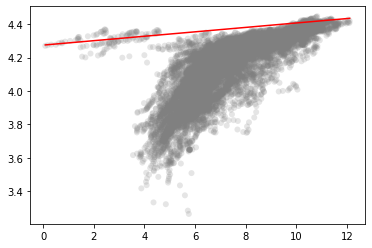

In [17]:
fig, ax = plt.subplots()
outlier_indices = model.weights == 0.0
ax.scatter(df[x_var], df[y_var], color="gray", edgecolor="none", alpha=0.2)
ax.scatter(df[x_var][outlier_indices], df[y_var][outlier_indices], color="red", marker="x", alpha=0.2)
ax.plot(df_pred[x_var], df_pred.pred, color="red")